In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.font_manager import FontProperties
import seaborn as sns
from glob import glob
import numpy as np
import matplotlib
import os
# matplotlib.rcParams.update({'font.size': 22})

In [2]:
with open('./species_order.txt') as f:
    sp_order = [line.strip() for line in f.readlines()]

In [3]:
def DrawHeatmap(df, figsize, title):
    sns.set(font_scale=1)
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title, fontsize=18)

    ax = sns.heatmap(df,
         center=0, vmin=-25, vmax=25,
         cmap='PuOr',
         linewidths=0.1, square=True)
    
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    return fig

def ParseFimo(fimo_output_file):
    
    ### read fimo output file
    motif_locs = pd.read_csv(fimo_output_file, sep='\t')
    
    ### filter for motifs with score > 0
    motif_locs = motif_locs[motif_locs['score'] > 0]
    
    ### extract some basic info
    motif_locs['anchor_gene'] = motif_locs['sequence_name'].str.split(':').str[0]
    motif_locs['midpoint'] = (motif_locs['start'] + motif_locs['stop']) / 2
    
    return motif_locs

def ScoreMotifs(ortho_proms):
    
    ### constants
    bins = 40
    prom_len = 200
    
    scores_df = pd.DataFrame(columns=[n for n in range(0, 200, int(200/bins))])

    ### group by one promoter sequence at a time
    for seq_name, seq_group in ortho_proms.groupby('sequence_name'):

        seq_scores = [0 for _ in range(0, prom_len, int(prom_len/bins))]

        ### sequences are named [anchor species protein id]:[target species]:[target species protein id]
        anchor_pid, target_sp, target_pid = seq_name.split(':')

        ### loop through all bins, and sum up all motifs where the midpoint falls into the bin
        for i, n in enumerate(range(0, prom_len, int(prom_len/bins))):

            motifs_in_bin = seq_group[(seq_group['midpoint'] > n) & (seq_group['midpoint'] <= n + prom_len/bins)]
            motifs_in_bin = motifs_in_bin.sort_values(by='score', ascending=False)

            if motifs_in_bin.shape[0] == 0:
                score = 0
            else:
                top_motif = motifs_in_bin.iloc[0]
                top_motif_score = top_motif['score']
                top_motif_strand = top_motif['strand'] 
                if top_motif_strand == '+':
                    strand_multiplier = 1
                else:
                    ### rev strand gets a negative score. this isn't really correct, but this allows the heatmap to have 2 colors
                    strand_multiplier = -1
                score = top_motif_score * strand_multiplier
                
            ### record score for this bin
            seq_scores[i] = score

        ### record scores for all bins for this sequence
        scores_df.loc[target_sp,:] = seq_scores
        
    return scores_df

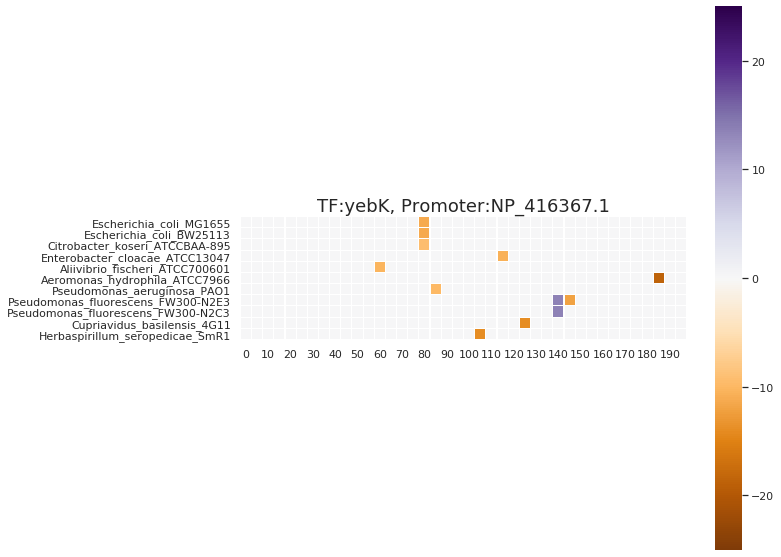

Nonzero: 12


In [5]:
i = 0
SCORE_CUTOFF = 9
for fimo_out in glob('../data/promoter_motifs_results/*_fimo/fimo.txt'):
    selected_tf = os.path.basename(os.path.dirname(fimo_out)).split('_')[0]
    
    motif_locs = ParseFimo(fimo_out)
    
    ### in this dataset, there's actually only a single "anchor gene" per fimo output, since I only considered autoregulator targets
    ### but this extra groupby keeps it general, so the script works if multiple TF target promoters (and their respective orthos) are also included
    for anchor_gene, ortho_proms in motif_locs.groupby('anchor_gene'):
        #Filter weak sites
        weak_filter = ortho_proms.score > SCORE_CUTOFF
        ortho_proms = ortho_proms[weak_filter]

        ### if less than 5 examples, skip
        if ortho_proms['sequence_name'].nunique() < 5:
            continue

        scores_df = ScoreMotifs(ortho_proms)
        scores_df = scores_df.reindex(sp_order).dropna()
        n_nonzero = (scores_df.dropna()!=0).sum(axis=1).sum()
        fig = DrawHeatmap(scores_df.astype(float), (10,10), f"TF:{selected_tf}, Promoter:{anchor_gene}")
        plt.show()        
        print(f"Nonzero: {n_nonzero}")
    i += 1
    if i>2:
        break

In [ ]:
i = 0
for fimo_out in glob('../data/promoter_motifs_results/*_fimo/fimo.txt'):
    selected_tf = os.path.basename(os.path.dirname(fimo_out)).split('_')[0]
    
    motif_locs = ParseFimo(fimo_out)
    for anchor_gene, ortho_proms in motif_locs.groupby('anchor_gene'):
        ### if less than 5 examples, skip
        if ortho_proms['sequence_name'].nunique() < 5:
            continue

        scores_df = ScoreMotifs(ortho_proms)
        scores_df = scores_df.reindex(sp_order)
        fig = DrawHeatmap(scores_df.astype(float), (10,10), f"TF:{selected_tf}, Promoter:{anchor_gene}")
        plt.show()        
    i += 1
    if i>2:
        break

In [ ]:
(scores_df.dropna()!=0).sum(axis=1).sum()

In [7]:
ortho_proms.head(2)

# motif_id motif_alt_id                                      sequence_name  \
0       yebK       MEME-1  NP_416367.1:Aeromonas_hydrophila_ATCC7966:YP_8...   
1       yebK       MEME-1  NP_416367.1:Cupriavidus_basilensis_4G11:WP_043...   

   start  stop strand    score       p-value  q-value       matched_sequence  \
0    176   196      -  18.7439  1.880000e-07  0.00326  CGTTTTTGTAATTTAGCTTCA   
1    120   140      -  14.0610  1.640000e-06  0.00713  TTTGAATGTTACTTTATAACA   

   anchor_gene  midpoint  
0  NP_416367.1     186.0  
1  NP_416367.1     130.0

In [8]:
scores_df

0   5   10  15  20  25  30  35  40  45   \
Escherichia_coli_MG1655              0   0   0   0   0   0   0   0   0   0   
Escherichia_coli_BW25113             0   0   0   0   0   0   0   0   0   0   
Citrobacter_koseri_ATCCBAA-895       0   0   0   0   0   0   0   0   0   0   
Enterobacter_cloacae_ATCC13047       0   0   0   0   0   0   0   0   0   0   
Aliivibrio_fischeri_ATCC700601       0   0   0   0   0   0   0   0   0   0   
Aeromonas_hydrophila_ATCC7966        0   0   0   0   0   0   0   0   0   0   
Pseudomonas_aeruginosa_PAO1          0   0   0   0   0   0   0   0   0   0   
Pseudomonas_fluorescens_FW300-N2E3   0   0   0   0   0   0   0   0   0   0   
Pseudomonas_fluorescens_FW300-N2C3   0   0   0   0   0   0   0   0   0   0   
Cupriavidus_basilensis_4G11          0   0   0   0   0   0   0   0   0   0   
Herbaspirillum_seropedicae_SmR1      0   0   0   0   0   0   0   0   0   0   

                                    ... 150 155 160 165 170 175 180      185  \
Escherichia_coli_MG1655             ...   0   0   0   0   0   0   0        0   
Escherichia_coli_BW25113            ...   0   0   0   0   0   0   0        0   
Citrobacter_koseri_ATCCBAA-895      ...   0   0   0   0   0   0   0        0   
Enterobacter_cloacae_ATCC13047      ...   0   0   0   0   0   0   0        0   
Aliivibrio_fischeri_ATCC700601      ...   0   0   0   0   0   0   0        0   
Aeromonas_hydrophila_ATCC7966       ...   0   0   0   0   0   0   0 -18.7439   
Pseudomonas_aeruginosa_PAO1         ...   0   0   0   0   0   0   0        0   
Pseudomonas_fluorescens_FW300-N2E3  ...   0   0   0   0   0   0   0        0   
Pseudomonas_fluorescens_FW300-N2C3  ...   0   0   0   0   0   0   0        0   
Cupriavidus_basilensis_4G11         ...   0   0   0   0   0   0   0        0   
Herbaspirillum_seropedicae_SmR1     ...   0   0   0   0   0   0   0        0   

                                   190 195  
Escherichia_coli_MG1655              0   0  
Escherichia_coli_BW25113             0   0  
Citrobacter_koseri_ATCCBAA-895       0   0  
Enterobacter_cloacae_ATCC13047       0   0  
Aliivibrio_fischeri_ATCC700601       0   0  
Aeromonas_hydrophila_ATCC7966        0   0  
Pseudomonas_aeruginosa_PAO1          0   0  
Pseudomonas_fluorescens_FW300-N2E3   0   0  
Pseudomonas_fluorescens_FW300-N2C3   0   0  
Cupriavidus_basilensis_4G11          0   0  
Herbaspirillum_seropedicae_SmR1      0   0  

[11 rows x 40 columns]